In [1]:
from functions import *
from functions import evaluate_dax
from functions import get_DAX
from models.DAX import DAX_baseline
from models.DAX import DAX_quantile_regression
import pandas as pd
import tqdm
from functions.prepare_data import split_time
from functions.evaluation import evaluate_horizon
from tqdm import tqdm
from datetime import datetime, date

In [2]:
daxdata=get_DAX.get()

baseline_model = {
    'name': 'Baseline Model',
    'function': DAX_baseline.DAX_baseline
}
quantile_model = {
    'name': 'Quantile Regression',
    'function': DAX_quantile_regression.DAX_quantile_regression
}



In [3]:
import datetime
date_str = '2023-01-01'
result = baseline_model['function'](daxdata, date_str=date_str)

NameError: name 'date_str' is not defined

In [4]:
df=DAX_baseline.DAX_baseline(daxdata)

In [5]:
import pandas as pd
from datetime import timedelta

def evaluate_daxmodel(model1, model2, df, start_date, end_date, last_x=5, years=False, months=False, weeks=True):
    '''
    Evaluate DAX models over a specified range of dates.
    Parameters:
    - model1, model2: Models to evaluate.
    - df: DataFrame containing the DAX data.
    - start_date, end_date: Start and end dates of the evaluation period.
    - last_x, years, months, weeks: Parameters to control the time split.
    '''
    date_range = pd.date_range(start=start_date, end=end_date)
    evaluation_model1 = pd.DataFrame()
    evaluation_model2 = pd.DataFrame()

    for current_date in date_range:
        df_before = df.copy()
        date_str = current_date.strftime('%Y-%m-%d')

        # Evaluate model1
        pred_model1 = model1['function'](df_before, date_str=date_str)
        evaluation_model1 = evaluate_and_append(evaluation_model1, pred_model1, df)

        # Evaluate model2
        pred_model2 = model2['function'](df_before, date_str=date_str)
        evaluation_model2 = evaluate_and_append(evaluation_model2, pred_model2, df)

        # Update df_before for the next iteration
        df_before, _ = split_time(df_before, num_years=years, num_months=months, num_weeks=weeks)

    return evaluation_model1, evaluation_model2


# Example usage
start_date = '2023-01-01'
end_date = '2023-01-31'


def evaluate_and_append(evaluation_df, pred, df):
    # Convert forecast_date to datetime if it's not already
    pred['forecast_date'] = pd.to_datetime(pred['forecast_date'])

    # Function to calculate the actual date of forecast
    def calculate_actual_forecast_date(row):
        forecast_date = row['forecast_date']
        horizon = pd.Timedelta(row['horizon'])
        return forecast_date + horizon

    # Apply the function to calculate the actual forecast date
    pred['actual_forecast_date'] = pred.apply(calculate_actual_forecast_date, axis=1)

    # Convert the timezone of actual_forecast_date to match that of df
    pred['actual_forecast_date'] = pred['actual_forecast_date'].dt.tz_localize('Europe/Berlin')

    # Merge predictions with actual data based on the actual forecast date
    merged_df = pd.merge(pred, df, left_on='actual_forecast_date', right_index=True, how='left')

    # Debug: Check merged DataFrame
    print("Merged DataFrame in evaluate_and_append:\n", merged_df)


    for index, row in merged_df.iterrows():
        quantile_preds = row[['q0.025', 'q0.25', 'q0.5', 'q0.75', 'q0.975']]
        observation = row['ret1']
        score = evaluate_horizon(quantile_preds, observation)
        merged_df.at[index, 'score'] = score

    evaluation_df = pd.concat([evaluation_df, merged_df])
    return evaluation_df
evaluation_model1, evaluation_model2 = evaluate_daxmodel(baseline_model, quantile_model, daxdata, start_date, end_date)


Merged DataFrame in evaluate_and_append:
   forecast_date target horizon    q0.025     q0.25      q0.5     q0.75  \
0    2023-01-01    DAX   1 day -3.321265 -0.546439  0.068631  0.718274   
1    2023-01-01    DAX   2 day -4.087895 -0.817404  0.080265  1.000970   
2    2023-01-01    DAX   5 day -5.259161 -0.912912  0.164214  1.232426   
3    2023-01-01    DAX   6 day -6.282629 -1.044070  0.203116  1.443441   
4    2023-01-01    DAX   7 day -6.735742 -1.091646  0.343478  1.594461   

     q0.975      actual_forecast_date          Open  ...      ret1      ret2  \
0  2.719772 2023-01-02 00:00:00+01:00  13992.709961  ...  1.040775 -0.017483   
1  3.570492 2023-01-03 00:00:00+01:00  14116.070312  ...  0.795802  1.836577   
2  4.628697 2023-01-06 00:00:00+01:00  14476.719727  ...  1.196103  0.819496   
3  5.367396 2023-01-07 00:00:00+01:00           NaN  ...       NaN       NaN   
4  6.259934 2023-01-08 00:00:00+01:00           NaN  ...       NaN       NaN   

       ret3      ret4      ret5 

In [ ]:
evaluation_model1.to_csv('../forecasts/evaluations/evaluation_DAX_baseline.csv')

In [6]:
evaluation_model2

,forecast_date,target,horizon,q0.025,q0.25,q0.5,q0.75,q0.975,actual_forecast_date,Open,...,ret2,ret3,ret4,ret5,lag_ret1,lag_ret2,lag_ret3,lag_ret4,lag_ret5,score
0,2023-01-01,DAX,1 day,-2.146732,-0.480537,0.001527,0.508445,1.686040,2023-01-02 00:00:00+01:00,13992.709961,...,-0.017483,1.026341,0.528502,0.916316,13923.589844,14071.719727,13925.599609,13995.099609,13940.929688,2.790037
1,2023-01-01,DAX,2 day,-0.239467,1.412230,1.998202,2.504450,4.035406,2023-01-03 00:00:00+01:00,14116.070312,...,1.836577,0.778319,1.822144,1.324304,14069.259766,13923.589844,14071.719727,13925.599609,13995.099609,3.195109
2,2023-01-01,DAX,5 day,-0.089087,1.632409,2.261871,2.718899,4.064714,2023-01-06 00:00:00+01:00,14476.719727,...,0.819496,2.975728,3.771530,4.812305,14436.309570,14490.780273,14181.669922,14069.259766,13923.589844,2.689315
3,2023-01-01,DAX,6 day,-0.967677,0.827741,1.499534,1.980733,3.251140,2023-01-07 00:00:00+01:00,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2023-01-01,DAX,7 day,-0.513234,1.159863,1.796705,2.205429,3.696325,2023-01-08 00:00:00+01:00,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,2023-01-31,DAX,1 day,-2.146732,-0.480537,0.001527,0.508445,1.686040,2023-02-01 00:00:00+01:00,15125.120117,...,0.360712,0.202500,0.315968,0.654945,15128.269531,15126.080078,15150.030273,15132.849609,15081.639648,1.030842
1,2023-01-31,DAX,2 day,-0.239467,1.412230,1.998202,2.504450,4.035406,2023-02-02 00:00:00+01:00,15275.000000,...,2.486763,2.501237,2.343025,2.456493,15180.740234,15128.269531,15126.080078,15150.030273,15132.849609,0.902176
2,2023-01-31,DAX,5 day,-0.089087,1.632409,2.261871,2.718899,4.064714,2023-02-05 00:00:00+01:00,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2023-01-31,DAX,6 day,-0.967677,0.827741,1.499534,1.980733,3.251140,2023-02-06 00:00:00+01:00,15367.040039,...,-1.058378,1.082146,1.428385,1.442859,15476.429688,15509.190430,15180.740234,15128.269531,15126.080078,6.483212


/Users/stephantimpe/anaconda3/envs/Forecasting_Challenge_2/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/stephantimpe/anaconda3/envs/Forecasting_Challenge_2/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/stephantimpe/anaconda3/envs/Forecasting_Challenge_2/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/stephantimpe/anaconda3/envs/Forecasting_Challenge_2/lib/python3.9/site-packages/seaborn/_oldc

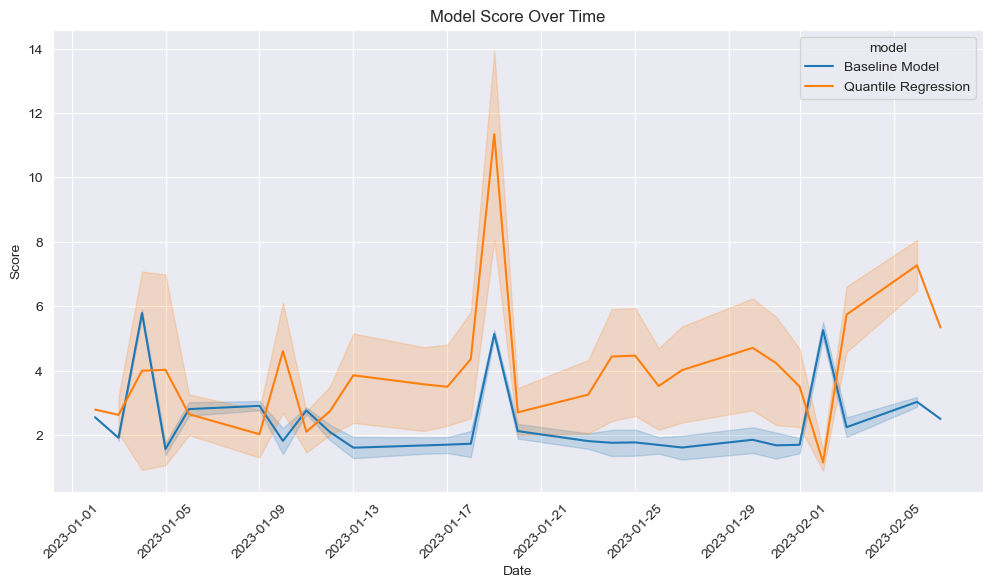

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming 'evaluation_model1' and 'evaluation_model2' are your DataFrames with the scores
# and they have a column named 'actual_forecast_date' for the date and 'score' for the score.

# Concatenate the two models' evaluations if needed
evaluation_model1['model'] = 'Baseline Model'
evaluation_model2['model'] = 'Quantile Regression'
combined_evaluation = pd.concat([evaluation_model1, evaluation_model2])


# Convert 'actual_forecast_date' to datetime if it's not already
combined_evaluation['actual_forecast_date'] = pd.to_datetime(combined_evaluation['actual_forecast_date'])
combined_evaluation = combined_evaluation.sort_values(by='actual_forecast_date')
combined_evaluation.dropna(subset=['score'], inplace=True)
combined_evaluation['actual_forecast_date'] = pd.to_datetime(combined_evaluation['actual_forecast_date'])
combined_evaluation['score'] = combined_evaluation['score'].astype(float)


plt.figure(figsize=(12, 6))
sns.lineplot(data=combined_evaluation, x='actual_forecast_date', y='score', hue='model')
plt.title('Model Score Over Time')
plt.xlabel('Date')
plt.ylabel('Score')
plt.xticks(rotation=45)  # Optional: Rotate x-axis labels for better readability
plt.show()


In [8]:
combined_evaluation.head()


,forecast_date,target,horizon,q0.025,q0.25,q0.5,q0.75,q0.975,actual_forecast_date,Open,...,ret3,ret4,ret5,lag_ret1,lag_ret2,lag_ret3,lag_ret4,lag_ret5,score,model
0,2023-01-01,DAX,1 day,-3.321265,-0.546439,0.068631,0.718274,2.719772,2023-01-02 00:00:00+01:00,13992.709961,...,1.026341,0.528502,0.916316,13923.589844,14071.719727,13925.599609,13995.099609,13940.929688,2.551554,Baseline Model
0,2023-01-01,DAX,1 day,-2.146732,-0.480537,0.001527,0.508445,1.686040,2023-01-02 00:00:00+01:00,13992.709961,...,1.026341,0.528502,0.916316,13923.589844,14071.719727,13925.599609,13995.099609,13940.929688,2.790037,Quantile Regression
1,2023-01-01,DAX,2 day,-4.087895,-0.817404,0.080265,1.000970,3.570492,2023-01-03 00:00:00+01:00,14116.070312,...,0.778319,1.822144,1.324304,14069.259766,13923.589844,14071.719727,13925.599609,13995.099609,2.007643,Baseline Model
0,2023-01-02,DAX,1 day,-3.321265,-0.546439,0.068631,0.718274,2.719772,2023-01-03 00:00:00+01:00,14116.070312,...,0.778319,1.822144,1.324304,14069.259766,13923.589844,14071.719727,13925.599609,13995.099609,1.816636,Baseline Model
1,2023-01-01,DAX,2 day,-0.239467,1.412230,1.998202,2.504450,4.035406,2023-01-03 00:00:00+01:00,14116.070312,...,0.778319,1.822144,1.324304,14069.259766,13923.589844,14071.719727,13925.599609,13995.099609,3.195109,Quantile Regression


In [9]:
import pandas as pd

# Assuming 'df' is your DataFrame
# df = pd.read_csv('your_combined_evaluation_data.csv')

# Aggregating scores by model and horizon
grouped_scores = combined_evaluation.groupby(['model', 'horizon'])['score'].agg(['mean', 'median', 'std'])

# Analyzing performance by forecast horizon
performance_by_horizon = combined_evaluation.groupby('horizon')['score'].agg(['mean', 'median', 'std'])

print(grouped_scores)
print(performance_by_horizon)


                                 mean    median       std
model               horizon                              
Baseline Model      1 day    1.905993  1.215568  1.331210
                    2 day    2.245593  1.561633  1.343575
                    5 day    2.257881  1.854590  1.039977
                    6 day    2.482105  2.105402  0.938882
                    7 day    2.633277  2.403337  0.862946
Quantile Regression 1 day    1.871849  1.034394  1.607817
                    2 day    4.607846  4.565586  2.635308
                    5 day    5.510582  5.334150  2.703407
                    6 day    3.586829  3.380769  2.096052
                    7 day    4.472021  4.398648  2.414818
             mean    median       std
horizon                              
1 day    1.888921  1.192511  1.459617
2 day    3.426720  2.753362  2.388275
5 day    3.884231  2.678913  2.608101
6 day    3.034467  2.469945  1.698730
7 day    3.552649  2.728955  2.019021


In [10]:
grouped_scores

mean    median       std
model               horizon                              
Baseline Model      1 day    1.905993  1.215568  1.331210
                    2 day    2.245593  1.561633  1.343575
                    5 day    2.257881  1.854590  1.039977
                    6 day    2.482105  2.105402  0.938882
                    7 day    2.633277  2.403337  0.862946
Quantile Regression 1 day    1.871849  1.034394  1.607817
                    2 day    4.607846  4.565586  2.635308
                    5 day    5.510582  5.334150  2.703407
                    6 day    3.586829  3.380769  2.096052
                    7 day    4.472021  4.398648  2.414818

In [ ]:
evaluation_model2['score'].mean()